# **Tutorial 4: Multi-agent task and motion planning**

As the number of robots in a system increases, the complexity of the planning problem increases significantly. The joint state space of the robots grows exponentially with the number of agents, making naive approaches infeasible for even moderately sized teams.

To address this challenge, research typically focuses on either
1. developing more **efficient algorithms for centralized approaches**, which treat the multi-robot team as a single composite system and plan in the joint state space, or
2. developing **decentralized approaches** where each robot plans its own trajectory and coordinates with others to collectively satisfy a global specification.

In this tutorial, **we focus on a centralized approach to multi-agent task and motion planning under Linear Temporal Logic (LTL) specifications**. The goal is to synthesize plans that ensure the team collectively satisfies high-level temporal logic tasks, such as sequencing or patrolling.

The straightforward method to finding such paths is to construct a product automaton from the environment model and the specification and then use standard graph search techniques. This involves two main steps
* loop detection (suffix): searching for loops in the PBA that start and end at an accepting state, and
* prefix computation: finding the shortest path from an initial state to the start of the loop.
This yields a minimal-cost prefix–suffix path that satisfies the LTL specification. This approach is similar to the method presented in Tutorial 3, but here it applies to multiple robots simultaneously.

The product automaton state space quickly grows as the number of robots in the fleet and the complexity of the LTL formula increases. As a result this centralized naive method is not suited for even moderately large systems, and more efficient planning techniques are required.

To overcome these limitations, this tutorial implements a centralized sampling-based method for multi-robot task and motion planning, based on the algorithm presented in [[1](https://doi.org/10.1109/TAC.2018.2853558),[2](https://doi.org/10.1177/0278364920913922)]. The authors introduce a sampling-based method which incrementally builds a tree that approximates the state-space of the product automaton. This tree is then searched for a minimal cost path that satisfies the LTL formula.

This approach significantly reduces computational complexity while still providing guarantees on finding a prefix–suffix path as the number of samples increases.


### **Task summary for each grade**
**E-level:** Implement a centralized sampling-based algorithm that constructs a prefix–suffix plan satisfying a given LTL specification, following the approach in [[1](https://doi.org/10.1109/TAC.2018.2853558)].

**C-level:** Introduce biased sampling toward accepting states of the non-deterministic Büchi automaton (NBA), as proposed in [[2](https://doi.org/10.1177/0278364920913922)]. Show empirically that the biased planner outperforms the unbiased one.

**A-level:** Use any method you can find in the literature, or come up with yourself to further improve the performance of the planning algorithm.

___
## **Pre-assignment imports and functions**

**Before starting the assignment, please run the cell below** to ensure that all necessary packages are imported and utility functions are defined. We have included all necessary imports for completing the assignment.

The imports have been **tested to work in google colab**, but if you are running the notebook locally you might need to install some of the packages using the installation instructions provided by the respective package/library.

### **Installs and imports**

In [1]:
"""Downloads and builds ltl3ba, buddy, and triangle libraries in a Colab environment."""

# download necessary libraries
!wget http://downloads.sourceforge.net/project/ltl3ba/ltl3ba/1.1/ltl3ba-1.1.3.tar.gz
!wget https://downloads.sourceforge.net/project/buddy/buddy/BuDDy%202.4/buddy-2.4.tar.gz
!wget https://netlib.org/voronoi/triangle.zip

# build buddy library
!tar xzf buddy-2.4.tar.gz
%cd buddy-2.4
!./configure
!make
!make install
%cd ..

# import os
# os.environ['LD_LIBRARY_PATH']+='/content/buddy-2.4/src/.libs/'

import os
libdir = "/content/buddy-2.4/src/.libs"
os.environ["LD_LIBRARY_PATH"] = (os.environ.get("LD_LIBRARY_PATH", "") + ":" + libdir).lstrip(":")

# unpack ltl3ba
!tar xzf ltl3ba-1.1.3.tar.gz

# build it
%cd ltl3ba-1.1.3/
!sed -i '36s#.*#BUDDY_INCLUDE=/content/buddy-2.4/src/#' Makefile
!sed -i '38s#.*#BUDDY_LIB=/content/buddy-2.4/src/.libs/#' Makefile
!make
%cd ..

# set the dynamic library path
import os
os.environ['LD_LIBRARY_PATH']='/content/buddy-2.4/src/.libs/'

# unpack triangle
!mkdir triangle
!unzip "/content/triangle.zip" -d "/content/triangle"

# build it
%cd triangle/
!make
%cd ..

--2025-12-15 23:15:41--  http://downloads.sourceforge.net/project/ltl3ba/ltl3ba/1.1/ltl3ba-1.1.3.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://twds.dl.sourceforge.net/project/ltl3ba/ltl3ba/1.1/ltl3ba-1.1.3.tar.gz?viasf=1 [following]
--2025-12-15 23:15:42--  http://twds.dl.sourceforge.net/project/ltl3ba/ltl3ba/1.1/ltl3ba-1.1.3.tar.gz?viasf=1
Resolving twds.dl.sourceforge.net (twds.dl.sourceforge.net)... 103.147.22.133
Connecting to twds.dl.sourceforge.net (twds.dl.sourceforge.net)|103.147.22.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49288 (48K) [application/x-gzip]
Saving to: ‘ltl3ba-1.1.3.tar.gz’

ltl3ba-1.1.3.tar.gz 100%[===================>]  48.13K  --.-KB/s    in 0.007s  

2025-12-15 23:15:42 (6.97 MB/

In [2]:
from shapely.geometry import Polygon, Point
import numpy as np
import pandas as pd
import subprocess
import queue
from collections import deque
import networkx as nx
import itertools
import networkx as nx
import re
import random
import time
from sympy.parsing.sympy_parser import parse_expr

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as pt
from matplotlib.lines import Line2D
from IPython.display import HTML
from matplotlib.animation import FuncAnimation



### **Setting up the environment**

Here we use the same code as in tutorial 3 to set up the environment.

In [3]:
"""DEFINITION OF REGIONS OF INTEREST"""

default_cost_per_unit = 1

class RegionOfInterest:
  def __init__(self, name, points, hole=None, cost_per_unit=default_cost_per_unit):
    self.name = name
    self.points = points
    self.hole = hole
    self.poly = Polygon(points)
    self.cpu = cost_per_unit

  def contains(self, x, y):
    result = self.poly.contains(Point(x, y))
    if isinstance(result, bool):
      return result
    else:
      return result[0]

# define workspace bounds
xmin = 0
xmax = 10
ymin = 0
ymax = 10

# define regions of interest
rois = [
    RegionOfInterest(
        name="staircase",
        points=[(0,10), (3,10), (3,8), (0,8)]
        #hole=(1.5,9)
    ),
    RegionOfInterest(
        name="charge",
        points=[(3,9), (3,10), (4,10), (4,9)],
    ),
    RegionOfInterest(
        name="wall1",
        points=[(6,4), (6,5), (9,5), (9,4)],
        hole=(8,4.5)
    ),
    RegionOfInterest(
        name="wall2",
        points=[(4,1), (4,4), (5,4), (5,1)],
        hole=(4.5,2)
    ),
    RegionOfInterest(
        name="wall3",
        points=[(2,4), (2,5), (5,5), (5,4)],
        hole=(3.5,4.5)
    ),
    RegionOfInterest(
        name="wall4",
        points=[(0,4), (0,5), (1,5), (1,4)],
        hole=(0.5,4.5)
    ),
    RegionOfInterest(
        name="wall5",
        points=[(6,5), (6,9), (7,9), (7,5)],
        hole=(6.5,7)
    ),
    RegionOfInterest(
        name="rooma",
        points=[(0,0), (0,4), (4,4), (4,0)],
    ),
    RegionOfInterest(
        name="roomb",
        points=[(7,5), (7,10), (10,10), (10,5)],
    ),
    RegionOfInterest(
        name="roomc",
        points=[(5,0), (5,4), (10,4), (10,0)],
    ),

]

rois_colors = {
    "staircase":"violet",
    "charge": "yellow",
    "rooma": "lightblue",
    "roomb": "lightgreen",
    "roomc": "salmon",
    "default": "lightgrey"
}

In [4]:
"""CREATE INPUT FILES READABLE BY TRIANGLE"""
# creates a .poly file from workspace and obstacles according to https://www.cs.cmu.edu/~quake/triangle.poly.html
def workspace_to_poly_file(xmin, xmax, ymin, ymax, regions):
  # vertices of the mesh - workspace corners and obstacle points
  num_vert = 4 + sum( [ len(reg.points) for reg in regions])
  vert_header = "#vertices\n%i 2 0 0\n"%num_vert
  vert_str = "0 %i %i\n"%(xmin, ymin)
  vert_str += "1 %i %i\n"%(xmin, ymax)
  vert_str += "2 %i %i\n"%(xmax, ymax)
  vert_str += "3 %i %i\n"%(xmax, ymin)

  vert_id = 4;
  for reg in regions:
    for (x,y) in reg.points:
      vert_str += "%i %f %f\n"%(vert_id, x, y)
      vert_id += 1

  # line segments that will be enforced in the triangulation
  num_seg = num_vert # since all shapes are closed
  seg_header = "#segments\n%i 0\n"%num_seg
  seg_str = "0 0 1\n1 1 2\n2 2 3\n3 3 0\n" # workspace bounds

  seg_id = 4
  vert_id = 4
  for reg in regions:
    for i in range(len(reg.points)):
      from_id = vert_id + i
      to_id = vert_id + i + 1 if i+1 < len(reg.points) else vert_id
      seg_str += "%i %i %i\n"%(seg_id, from_id, to_id)
      seg_id += 1
    vert_id += len(reg.points)

  # holes
  num_holes = 0
  hole_str = ""
  for reg in regions:
    if reg.hole is not None:
      hole_str += "%i %f %f\n"%(num_holes, reg.hole[0], reg.hole[1])
      num_holes += 1
  hole_header = "#holes\n%i\n"%num_holes

  with open("workspace.poly", "w") as f:
    f.write(vert_header + vert_str + seg_header + seg_str + hole_header + hole_str)


"""
PARSE TRIANGLE OUTPUT FILES
"""

# assumes [file_name].1.node and [file_name].1.ele to exist
def parse_triangle(file_name="workspace"):
  vertices = []
  faces = []

  # read vertex positions
  with open(file_name+".1.node", encoding = 'utf-8') as f:
    # first line contains info about number of vertices etc, see: https://www.cs.cmu.edu/~quake/triangle.node.html
    first_line = next(f).strip().split()
    assert len(first_line) == 4
    assert first_line[1] == "2" # 2d vertices
    num_vert = int(first_line[0])
    for line in f:
      values = line.strip().split()
      if values[0].isnumeric():
        x = float(values[1])
        y = float(values[2])
        vertices.append((x,y))
    assert num_vert == len(vertices)

  # read face indices
  with open(file_name+".1.ele", encoding = 'utf-8') as f:
    # first line contains info about number of vertices etc, see: https://www.cs.cmu.edu/~quake/triangle.ele.html
    first_line = next(f).strip().split()
    assert len(first_line) == 3
    assert first_line[1] == "3" # each triangle has 3 nodes
    num_face = int(first_line[0])

    for line in f:
      values = line.strip().split()
      if values[0].isnumeric():
        assert len(values) == 4
        faces.append((int(values[1]), int(values[2]), int(values[3])))
    assert num_face == len(faces)

  return np.array(vertices), np.array(faces)


"""
CALL TRIANGLE
"""
def call_triangle(filename="workspace.poly", max_area=None):
  options = ["triangle/triangle", "-p", "-q", filename, "-D"]
  if max_area is not None:
    options.insert(1, "-a%f"%max_area)
  subprocess.run(options)

In [5]:
"""FUNCTIONS TO VISUALIZE RESULTS"""

def centroid(points):
    x = 0
    y = 0
    for p in points:
        assert len(p) == 2
        x += p[0]
        y += p[1]
    x /= len(points)
    y /= len(points)
    return (x, y)


def normalized_alpha_by_cost(points, rois, max_cost):
    default_alpha = 0.4  # @param {type:"slider", min:0.0, max:1.0, step:0.1}
    min_cost = 1
    min_alpha = 0.1  # @param {type:"slider", min:0.0, max:1.0, step:0.1}
    max_alpha = 0.7  # @param {type:"slider", min:0.0, max:1.0, step:0.1}

    # if all costs are the same
    if max_cost == min_cost:
        return default_alpha

    # find cost of this face
    cost = None
    for roi in rois:
        x, y = centroid(points)
        if roi.contains(x, y):
            cost = roi.cpu
            break

    # does not belong to a region of interest, default cost
    if cost is None:
        return min_alpha

    # otherwise linear map from cost in [min_cost, max_cost] to [min_alpha, max_alpha]
    alpha = (cost - min_cost) * (max_alpha - min_alpha) / (max_cost - min_cost) + min_alpha
    return alpha

def viz_mesh(vertices, faces, rois, highlight=[]):
    # find highest cost area
    highest_cost = 1
    for roi in rois:
        if roi.cpu > highest_cost:
            highest_cost = roi.cpu

    patches = []
    for (i, f) in enumerate(faces):
        # get coords for the face
        coords = np.zeros(6).reshape(3, 2)
        for j in range(3):
            coords[j] = vertices[f[j]]

        # default faces are blue, path highlight is red, roi faces are yellow
        color = rois_colors["default"]
        if i in highlight:
            color = "r"
        else:
            for roi in rois:
                x, y = centroid(coords)
                if roi.contains(x, y):
                    color = rois_colors[roi.name]
                    break

        # depending on region cost, appropriate alpha is chosen
        alpha = normalized_alpha_by_cost(coords, rois, highest_cost)
        polygon = pt.Polygon(coords, closed=True, fill=True, facecolor=color, edgecolor=color, alpha=alpha)
        patches.append(polygon)

    # make legend for the regions of interest
    legend_patches = []
    for roi_name, color in rois_colors.items():
        if roi_name == "default":
            name = "No label"
        else:
            name = roi_name
        legend_patches.append(pt.Patch(color=color, label=name))

    fig, ax = plt.subplots()
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    plt.scatter(vertices[:, 0], vertices[:, 1], s=2)
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("Robot environment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    plt.show()



def viz_mesh_multi_agent_paths(vertices, faces, rois, prefix_path, suffix_path, robot_transition_systems):
    """
    Visualize the workspace mesh with ROIs and overlay multi-agent prefix/suffix paths.
    """
    # find highest cost area for transparency scaling
    highest_cost = max([roi.cpu for roi in rois]) if rois else 1

    patches = []
    for (i, f) in enumerate(faces):
        coords = np.zeros((3, 2))
        for j in range(3):
            coords[j] = vertices[f[j]]

        # default face color
        color = rois_colors.get("default", "lightblue")

        # recolor if inside ROI
        for roi in rois:
            x, y = centroid(coords)
            if roi.contains(x, y):
                color = rois_colors.get(roi.name, "lightblue")
                break

        alpha = normalized_alpha_by_cost(coords, rois, highest_cost)
        polygon = pt.Polygon(coords, closed=True, fill=True, facecolor=color, edgecolor="k", alpha=alpha)
        patches.append(polygon)

    # --- create figure ---
    fig, ax = plt.subplots(figsize=(8, 6))
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    plt.scatter(vertices[:, 0], vertices[:, 1], s=2, color="k", zorder=2)

    # --- ROI legend ---
    roi_legend = []
    for roi_name, color in rois_colors.items():
        label = "No label" if roi_name == "default" else roi_name
        roi_legend.append(pt.Patch(color=color, label=label))

    # --- robot colors ---
    n_robots = len(robot_transition_systems)
    # Options: tab10, tab20, Set1, Set2, Set3, Accent, Dark2, Paired, Pastel1, Pastel2
    robot_colors = plt.get_cmap("Set2").colors[:n_robots]

    def get_robot_points(path, robot_idx):
        """Extract centroids for robot_idx along given joint path."""
        points = []
        for joint_state in path:
            # handle both PTS-only and PBA states
            if isinstance(joint_state[0], tuple):
                state = joint_state[0][robot_idx]
            else:
                state = joint_state[robot_idx]
            face_points = robot_transition_systems[robot_idx].nodes[state]['points']
            cx, cy = centroid(face_points)
            points.append((cx, cy))
        return np.array(points)

    # --- plot robot paths ---
    for i in range(n_robots):
        # PREFIX
        if prefix_path:
            prefix_points = get_robot_points(prefix_path, i)
            if len(prefix_points) > 0:
                plt.plot(prefix_points[:, 0], prefix_points[:, 1],
                         linestyle='-', linewidth=2, color=robot_colors[i],
                         label=f'Robot {i+1} prefix', zorder=3)
                plt.scatter(prefix_points[0, 0], prefix_points[0, 1],
                            color=robot_colors[i], marker='o', s=50, edgecolors='k', zorder=4)
                plt.scatter(prefix_points[-1, 0], prefix_points[-1, 1],
                            color=robot_colors[i], marker='x', s=50, zorder=4)  # removed edgecolors

        # SUFFIX
        if suffix_path:
            suffix_points = get_robot_points(suffix_path, i)
            if len(suffix_points) > 0:
                plt.plot(suffix_points[:, 0], suffix_points[:, 1],
                         linestyle=':', linewidth=2, color=robot_colors[i],
                         label=f'Robot {i+1} suffix', zorder=3)
                plt.scatter(suffix_points[0, 0], suffix_points[0, 1],
                            color=robot_colors[i], marker='s', s=50, edgecolors='k', zorder=4)
                plt.scatter(suffix_points[-1, 0], suffix_points[-1, 1],
                            color=robot_colors[i], marker='^', s=50, edgecolors='k', zorder=4)

    # --- legends ---
    prefix_line = Line2D([0], [0], color='k', linestyle='-', lw=2, label='Prefix path')
    suffix_line = Line2D([0], [0], color='k', linestyle=':', lw=2, label='Suffix path')

    robot_legend = [Line2D([0], [0], color=robot_colors[i], lw=3, label=f'Robot {i+1}')
                    for i in range(n_robots)]

    # Combine all legends
    first_legend = plt.legend(handles=roi_legend, title="Regions of Interest",
                              bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.add_artist(first_legend)
    second_legend = plt.legend(handles=robot_legend + [prefix_line, suffix_line],
                               title="Paths", bbox_to_anchor=(1.05, 0.45), loc='upper left')

    # --- finalize plot ---
    plt.title("Multi-Agent Paths on Workspace Mesh")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


def animate_mesh_multi_agent_paths(vertices, faces, rois, prefix_path, suffix_path, robot_transition_systems, interval=300):
    """
    Animate the workspace mesh with ROIs and overlay multi-agent prefix/suffix paths.
    Prefix is played once and remains visible; suffix loops 10 times.
    Handles empty prefix or suffix paths safely.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    patches = []

    highest_cost = max([roi.cpu for roi in rois]) if rois else 1

    for f in faces:
        coords = vertices[f]
        color = rois_colors.get("default", "lightblue")
        for roi in rois:
            x, y = centroid(coords)
            if roi.contains(x, y):
                color = rois_colors.get(roi.name, "lightblue")
                break
        alpha = normalized_alpha_by_cost(coords, rois, highest_cost)
        polygon = pt.Polygon(coords, closed=True, fill=True,
                             facecolor=color, edgecolor="k", alpha=alpha)
        ax.add_patch(polygon)
        patches.append(polygon)

    plt.scatter(vertices[:, 0], vertices[:, 1], s=2, color="k", zorder=2)

    # --- robot setup ---
    n_robots = len(robot_transition_systems)
    robot_colors = plt.get_cmap("Set2").colors[:n_robots]

    # Separate lines for prefix (static) and suffix (animated)
    prefix_lines = [ax.plot([], [], color=robot_colors[i], lw=2, linestyle='-')[0] for i in range(n_robots)]
    suffix_lines = [ax.plot([], [], color=robot_colors[i], lw=2, linestyle=':')[0] for i in range(n_robots)]

    robot_dot = [ax.scatter([], [], s=50, color=robot_colors[i], zorder=4) for i in range(n_robots)]
    prefix_start_dot = [ax.scatter([], [], s=80, marker='o', color=robot_colors[i], edgecolors='k', zorder=5) for i in range(n_robots)]
    prefix_end_dot   = [ax.scatter([], [], s=80, marker='x', color=robot_colors[i], zorder=5) for i in range(n_robots)]
    suffix_start_dot = [ax.scatter([], [], s=80, marker='s', color=robot_colors[i], edgecolors='k', zorder=5) for i in range(n_robots)]
    suffix_end_dot   = [ax.scatter([], [], s=80, marker='^', color=robot_colors[i], edgecolors='k', zorder=5) for i in range(n_robots)]

    # --- prepare points ---
    def get_robot_points(path, robot_idx):
        points = []
        for joint_state in path:
            if isinstance(joint_state[0], tuple):
                state = joint_state[0][robot_idx]
            else:
                state = joint_state[robot_idx]
            face_points = robot_transition_systems[robot_idx].nodes[state]['points']
            cx, cy = centroid(face_points)
            points.append((cx, cy))
        return np.array(points)

    prefix_points_all = [get_robot_points(prefix_path, i) for i in range(n_robots)] if prefix_path else [[] for _ in range(n_robots)]
    suffix_points_all = [get_robot_points(suffix_path, i) for i in range(n_robots)] if suffix_path else [[] for _ in range(n_robots)]

    total_prefix = len(prefix_path) if prefix_path else 0
    total_suffix = len(suffix_path) if suffix_path else 0

    # --- animation update ---
    def update(frame):
        if total_prefix > 0 and frame < total_prefix:
            # PREFIX animation
            for i in range(n_robots):
                pts = prefix_points_all[i][:frame+1]
                if len(pts) > 0:
                    prefix_lines[i].set_data(pts[:, 0], pts[:, 1])
                    robot_dot[i].set_offsets(pts[-1])
                    prefix_start_dot[i].set_offsets(pts[0])
                    prefix_end_dot[i].set_offsets(pts[-1])
                suffix_start_dot[i].set_offsets((-1e6, -1e6))
                suffix_end_dot[i].set_offsets((-1e6, -1e6))

        elif total_suffix > 0:
            # SUFFIX loop
            s_frame = (frame - total_prefix) % total_suffix
            for i in range(n_robots):
                pts = suffix_points_all[i][:s_frame+1]
                if len(pts) > 0:
                    suffix_lines[i].set_data(pts[:, 0], pts[:, 1])
                    robot_dot[i].set_offsets(pts[-1])
                    suffix_start_dot[i].set_offsets(pts[0])
                    suffix_end_dot[i].set_offsets(pts[-1])
                # keep prefix visible only if nonempty
                if total_prefix > 0 and len(prefix_points_all[i]) > 0:
                    prefix_lines[i].set_data(prefix_points_all[i][:, 0], prefix_points_all[i][:, 1])
                    prefix_start_dot[i].set_offsets(prefix_points_all[i][0])
                    prefix_end_dot[i].set_offsets(prefix_points_all[i][-1])
                else:
                    prefix_start_dot[i].set_offsets((-1e6, -1e6))
                    prefix_end_dot[i].set_offsets((-1e6, -1e6))

        return (
            prefix_lines + suffix_lines +
            robot_dot + prefix_start_dot + prefix_end_dot +
            suffix_start_dot + suffix_end_dot
        )

    # --- animation frames ---
    n_frames = total_prefix + total_suffix * 5 if total_suffix > 0 else total_prefix
    ani = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)

    # --- legends ---
    roi_legend = []
    for roi_name, color in rois_colors.items():
        label = "No label" if roi_name == "default" else roi_name
        roi_legend.append(pt.Patch(color=color, label=label))

    prefix_line = Line2D([0], [0], color='k', linestyle='-', lw=2, label='Prefix')
    suffix_line = Line2D([0], [0], color='k', linestyle=':', lw=2, label='Suffix')
    robot_legend = [Line2D([0], [0], color=robot_colors[i], lw=3, label=f'Robot {i+1}') for i in range(n_robots)]

    first_legend = plt.legend(handles=roi_legend, title="Regions of Interest",
                              bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.add_artist(first_legend)
    second_legend = plt.legend(handles=robot_legend + [prefix_line, suffix_line],
                               title="Paths", bbox_to_anchor=(1.05, 0.45), loc='upper left')

    plt.title("Multi-Agent Paths on Workspace Mesh")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.tight_layout()
    plt.close()

    return ani

___
# **E-level**
You will implement a centralized sampling-based planner for a team of robots under an LTL specification. The goal is to construct prefix–suffix paths in the PBA tree approximation while minimizing the total travel cost of the robot fleet.

0. Set up the workspace mesh and specify the task.
1. Create the WTS for each robot in the fleet, given the discretization of the environment.
2. Implement functions for the PTS.
3. Implement functions for the PBA.
4. Implement the sampling-based algorithm to find a prefix-suffix path in the approximated PBA tree.

## **Task 0.1: Create the workspace mesh**

The environment used in this tutorial is the same as in Tutorial 3.

The robots are operating in a workspace $\mathcal{W} \subset \mathbb{R}^2$. We assume the workspace is a rectangular subset of $\mathbb{R}^2$ that is divided into $W$ disjoint polygon regions.

Run the cells below to build and visualize the workspace and the different labelled regions of the environment.

In [6]:
# create input file
workspace_to_poly_file(xmin, xmax, ymin, ymax, regions=rois)

# call triangle
max_area = 2 #@param {type:"slider", min:0.1, max:5.0, step:0.1}
call_triangle(max_area=max_area)

# parse output
vert, faces = parse_triangle()

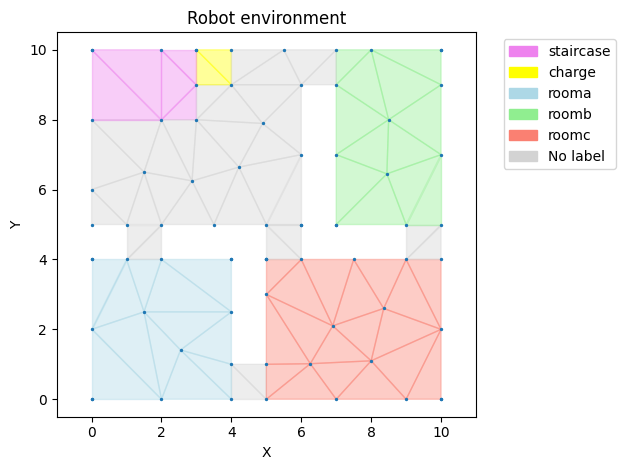

In [7]:
# visualize the result
viz_mesh(vert, faces, rois)

## **Task 0.2: Non-deterministic Büchi automata**

### **Theory**
The robots have to accomplish a collaborative task specified as a Linear Temporal Logic (LTL) formula $\phi$ over the set of atomic propositions $\mathit{AP}$. The task is global, meaning it refers to the combined behaviour of all robots in the system. An LTL formula can be converted into a non-deterministic Büchi automaton (NBA), which accepts all traces that satisfy the formula [3].

An NBA over the alphabet $\Sigma$ is a tuple
$$\mathcal{A}_\phi=(Q, q_0, \Sigma, \delta, F)$$
where
* $Q$ is a finite set of states;
* $q_0 \in Q$ is the initial state;
* $\Sigma = 2^\mathit{AP}$ is the input alphabet, i.e., all possible combinations of propositions that may hold at a given time;
* $\delta : Q \times \Sigma \rightarrow 2^Q$ is a transition function, defining how the automaton moves between states based on the propositions that hold; and
* $F \subseteq Q$ is a finite set of accepting (final) states.

Here, $2^{\{\cdot\}}$ denotes the power set operator.

In the class below we use the `ltl3ba` tool to convert an LTL formula $\phi$ into an equivalent NBA $\mathcal{A}_\phi$. You do not need to modify this code, or implement any additional functionality here. Just run the cell to define the `NBA` class.

In [8]:
class NBA:
    def __init__(self, formula:str, print_ltl3ba:bool=False):
        self.formula = formula
        self.graph = nx.DiGraph()
        self.graph.graph["accept"] = []  # store accepting states here
        self.graph.graph["init"] = None  # store initial state
        self._ltl_to_nba(print_ltl3ba)

    def _ltl_to_nba(self, print_ltl3ba):
        # CHANGE: Use "ltl3ba" directly since it's in the container's system PATH (/usr/local/bin/)
        raw = subprocess.check_output(["ltl3ba-1.1.3/ltl3ba", "-f", self.formula])
        lines = raw.decode('utf-8').split("\n")

        for line in lines:
            if print_ltl3ba:
                print(line)

            if "never" in line or "}" in line or len(line) == 0:
                continue

            # State line
            if line[0] != "\t":
                self.state = line.strip(":")
                self.graph.add_node(self.state)
                if "init" in self.state:
                    self.graph.graph["init"] = self.state
                if "accept" in self.state:
                    self.graph.graph["accept"].append(self.state)
            else:
                # Edge description
                if line[1] == ":":
                    guard = re.search(r"\t:: (.*) -> goto", line).group(1)
                    guard = guard.replace("||", "|").replace("&&", "&").replace("!", "~")
                    parsed_guard = parse_expr(guard)
                    state_to = re.search(r"-> goto (.*)", line).group(1)
                    self.graph.add_edge(self.state, state_to, guard=parsed_guard)

                # Self-loop with true guard
                if line.strip() == "skip":
                    self.graph.add_edge(self.state, self.state, guard=parse_expr("True"))

    def initial_state(self):
        return self.graph.graph["init"]

    def accepting_states(self):
        return self.graph.graph["accept"]

    def get_nodes(self):
        return self.graph.nodes()

    def get_successors(self, q):
        return self.graph.successors(q)

    def number_of_nodes(self):
        return self.graph.number_of_nodes()

    def plot(self, show_guards=False):
        """
        Plot the NBA using matplotlib and networkx.
        :param show_guards: whether to display edge guards
        """
        try:
            from networkx.drawing.nx_agraph import graphviz_layout
            pos = graphviz_layout(self.graph, prog="dot")  # hierarchical layout
        except ImportError:
            pos = nx.spring_layout(self.graph, seed=42)  # fallback

        labels = {node: node for node in self.graph.nodes()}
        edge_labels = {(u, v): f"{data['guard']}" for u, v, data in self.graph.edges(data=True)}

        # Corrected: access graph attributes from .graph
        accept_nodes = self.graph.graph.get("accept", [])
        normal_nodes = [n for n in self.graph.nodes() if n not in accept_nodes]

        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=normal_nodes,
            node_color='lightblue',
            node_size=1000,
            edgecolors='none'
        )
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=accept_nodes,
            node_color='lightblue',
            node_size=1000,
            edgecolors='black',
            linewidths=2
        )

        nx.draw_networkx_labels(self.graph, pos, labels=labels, font_size=8)
        nx.draw_networkx_edges(
            self.graph, pos,
            arrows=True,
            arrowsize=20,
            connectionstyle='arc3,rad=0.1',
            node_size=1000,
            edge_color='black'
        )

        if show_guards:
            nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_color='black')

        plt.axis("off")
        plt.show()

### **Task instructions**
Here, we create an NBA from an LTL formula that defines the global task for the robot fleet.

The formula you should use specifies that the robots must continuously repeat the sequence of visiting room *a* and *charge*, followed by rooms *b* and *c*, while always avoiding the *staircase* area. I.e. the team must cooperate to be in the different locations at the same time.

This is specified by the formula:
$$\phi = G\,F\,\bigl((rooma \land charge) \land G\,F\,(roomb \land roomc)\bigr) \land G\bigl(\neg staircase\bigr).$$

Run the code in the cell below to create the NBA for this formula, and visualize it. By setting `show_guards=True`, the transitions will be labelled with the corresponding input propositions that trigger them.

Initial state: T0_init
Number of states: 4
Number of accepting states: 1


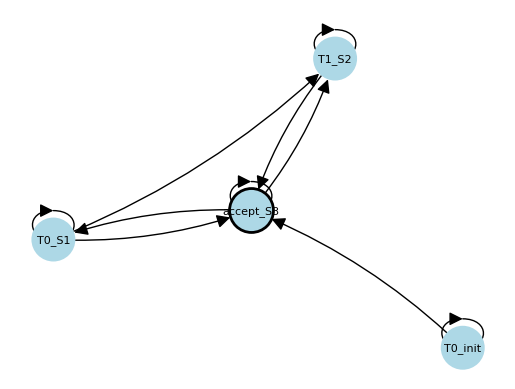

In [9]:
spec = "GF((rooma && charge) && GF(roomb && roomc)) && G(!staircase)"

nba = NBA(spec)
print("Initial state:", nba.initial_state())
print("Number of states:", nba.number_of_nodes())
print("Number of accepting states:", len(nba.accepting_states()))
nba.plot(show_guards=False)

## **Task 1: create the robot transition systems**

### **Theory: WTS**
For each robot, you need to represent its motion in the discretized workspace as a weighted transition system (WTS).

Recall, the robots are operating in a workspace $\mathcal{W} \subset \mathbb{R}^2$ that is divided into $W$ disjoint polygon regions.  Let the $j^{th}$ region be denoted $r_j$.

Each robot $i \in \{1,2,\dots,N\}$ is modelled as a weighted transition system (WTS), defined by the tuple:
$$\mathcal{T}_i=(S_i, s^0_i, \rightarrow_i, \mathit{AP}_i, L_i, w_i)$$
where
* $S_i = \bigcup_{j=1}^W \{s_i^{r_j}\}$ is a finite set of states, where a state $s_i^{r_j}$ indicates that robot $i$ is in the region $r_j$;
* $s^0_i \in S_i$ is the initial state;
* $\rightarrow_i : S_i \times S_i$ is the transition relation for robot $i$. Given the robot dynamics, if there exists a control input $\mathbf{u}_i$ that can drive robot $i$ from a region $r_j$ to a region $r_k$, then there exists a transition from $s_i^{r_j}$ to $s_i^{r_k}$, denoted $(s_i^{r_j},s_i^{r_k}) \in \rightarrow_i$;
* $\mathit{AP}_i$ is a finite set of atomic propositions relevant to robot $i$;
* $L_i : S_i \rightarrow 2^{\mathit{AP}_i}$ is a state labelling function that specifies which propositions are true in each state; and
* $w_i: S_i \times S_i \rightarrow \mathbb{R}_+$ is the weight function, which assigns each edge a positive cost. In this tutorial $w(s_i^{r_j}, s_i^{r_k})$ represents the distance that robot $i$ needs to travel in order to move from state $s_i^{r_j}$ to state $s_i^{r_k}$

We assume that the robot can move freely between any two adjacent regions in the workspace, i.e., if two triangles in the workspace share an edge, the robot can transition between them. Self-transitions (transition from a state to itself) should be included as well. This simplification ignores robot dynamics and collision avoidance but allows us to focus on the multi-agent task planning aspect of the problem.

### **Task instructions**
Implement the following functions to create the WTS for each robot in the fleet:
1. `build_transition_system`
2. `set_initial_state`

and use them to create the WTS for each robot.

Set the number of robots to $N=2$, and have the initial location be at the **charge** region. Build a WTS for each robot, and store them in a list `robot_ts_list`, where the $i^{th}$ element is the transition system for robot $i$.

**Hints:**
* You can use your code from tutorial 3 as a starting point, but modify it to fit the instructions below.
* You will have the option to make the transition system weighted or not. If you completed tutorial 3 C-level, you can use that code as a starting point for weighted transitions. If you did not complete tutorial 3 C-level just set all weights to 1, and no computation of weights is required.
* We assume all robot WTSs are the same, except they may have different initial states.



In [12]:
def build_transition_system(faces:list, verts:list, rois:list) -> nx.DiGraph:
    ts = nx.DiGraph()

    # SOLUTION STARTS HERE
    ts.graph.setdefault('ap', set())

    # nodes: one per triangle face
    for i, f in enumerate(faces):
        points = [tuple(verts[int(f[0])]), tuple(verts[int(f[1])]), tuple(verts[int(f[2])])]
        cx, cy = centroid(points)

        labels = set()
        for roi in rois:
            if roi.contains(cx, cy):
                labels.add(roi.name)

        ts.add_node(i, points=points, labels=labels)
        ts.graph.setdefault('ap', set()).update(labels)

    # adjacency via shared mesh edges (two shared vertices)
    edge_to_faces = {}
    for i, f in enumerate(faces):
        a, b, c = int(f[0]), int(f[1]), int(f[2])
        for u, v in [(a, b), (b, c), (c, a)]:
            e = (u, v) if u < v else (v, u)
            edge_to_faces.setdefault(e, []).append(i)

    # self-loops
    for i in range(len(faces)):
        ts.add_edge(i, i, weight=1)

    # neighbor transitions (bidirectional)
    for face_ids in edge_to_faces.values():
        if len(face_ids) >= 2:
            for u, v in itertools.permutations(face_ids, 2):
                ts.add_edge(u, v, weight=1)

    return ts


def set_initial_state(ts:nx.DiGraph, proposition:str) -> nx.DiGraph:
    # SOLUTION STARTS HERE
    for n, data in ts.nodes(data=True):
        if proposition in data["labels"]:
            ts.graph['init'] = n
            break
    return ts


In [13]:
N = 2 # number of robots
initial_props = ["charge", "charge"] # initial props for each robot

robot_ts_list = []
for i in range(N):
    ts = build_transition_system(faces, vert, rois)
    ts = set_initial_state(ts, initial_props[i])
    robot_ts_list.append(ts)
    print("Number of states:", len(ts.nodes()))
    print("Number of transitions:", len(ts.edges()))

Number of states: 81
Number of transitions: 277
Number of states: 81
Number of transitions: 277


## **Task 2: product transition system**


### **Theory: PTS**
To capture the joint behavior of all $N$ robots, the individual WTSs can be combined into a product transition system (PTS):
$$\mathcal{T}_{PTS} = \mathcal{T}_1 \otimes \mathcal{T}_2 \otimes \dots \otimes \mathcal{T}_N = (S_{PTS}, s^0_{PTS}, \rightarrow_{PTS}, \mathit{AP}, L_{PTS}, w_{PTS})$$
where
* $S_{PTS} = S_1 \times S_2 \times \dots \times S_N$ is the set of joint states;
* $s^0_{PTS} = (s^0_1, s^0_2, \dots, s^0_N) \in S_{PTS}$ is the initial joint state;
* $\rightarrow_{PTS} \subseteq S_{PTS} \times S_{PTS}$ is the joint transition relation, where there exists a transition from a state $s_{PTS} = (s_1, s_2, \dots, s_N) \in S_{PTS}$ to a state $s'_{PTS} = (s'_1, s'_2, \dots, s'_N) \in S_{PTS}$, denoted $(s_{PTS}, s'_{PTS}) \in \rightarrow_{PTS}$, if and only if each individual robot can make the corresponding transition in their WTS $\mathcal{T}_i$, i.e., $(s_i, s'_i) \in \rightarrow_i$ for all $i \in \{1,2,\dots,N\}$;
* $\mathit{AP} = \bigcup_{i=1}^N \mathit{AP}_i$ is the set of atomic propositions;
* $L_{PTS} : S_{PTS} \rightarrow 2^{\mathit{AP}}$ is the state labelling function defined as the union of the labels of all the robots: $L_{PTS}(s_{PTS}) = \bigcup_{i=1}^N L_i(s_i)$, meaning that a proposition is true in the joint state if it is true for at least one of the robot's states in their own WTS; and
* $w_{PTS} : S_{PTS} \times S_{PTS} \rightarrow \mathbb{R}_+$ is the weight function, which assigns each edge a positive cost. In this tutorial the cost for a joint transition is the sum of the costs of the individual transitions, i.e., $w_{PTS}((s_1, s_2, \dots, s_N), (s'_1, s'_2, \dots, s'_N)) = \sum_{i=1}^N w_i(s_i, s'_i)$.

Each robot state evolves according to its own WTS, and the PTS captures the joint evolution of all robots together, and the cost of a joint transition is the sum of the costs of the individual transitions.

An infinite path on the PTS is an infinite sequence of states
$$\pi = \rho_1 \rho_2 \rho_3 \dots$$
where $\rho_1 = s^0_{PTS}$ is the initial state, $\rho_k \in S_{PTS}$ for all $k \geq 1$, and $(\rho_k, \rho_{k+1}) \in \rightarrow_{PTS}$ for all $k \geq 1$.

A finite path $\pi = \rho_1 \rho_2 \dots \rho_K$ in the PTS has an associated cost
$$J(\pi) = \sum_{j=1}^{K-1} w_{PTS}(\rho_j, \rho_{j+1}),$$
where $w_{PTS}(\rho_j, \rho_{j+1})$ denotes the transition weight between consecutive joint states. In other words, the cost of a finite path is the total weight accumulated over all transitions along $\pi$, reflecting the total travel distance of the team of robots.

### **Task instructions**
You do not need to explicitly construct the full PTS, as it grows exponentially with the number of robots. However, you need to implement functions that will be used in the sampling-based algorithm to verify and retrieve information about joint states and joint transitions in the PTS.

Implement the following functions:
1. `is_valid_joint_state`
2. `is_valid_transition`

Although the sampling-based algorithm does not require constructing the full PTS, you still need to implement some functions below to verify if joint states and joint transitions are valid. Implement the code below using the definition given for the PTS.

In [14]:
class PTS:
    def __init__(self, ts_list:list[nx.DiGraph]):
        """
        Class to maintain the Product Transition System (PTS) from a list of robot transition systems.
        Caches results of query methods for efficiency.

        Args:
            ts_list: the individual robot WTSs
        """

        # Caches used to speed up lookup later
        self._valid_transitions_cache = {}
        self._labels_cache = {}
        self._successors_cache = {}
        self._transition_cost_cache = {}

        # All possible joint states (may include invalid ones)
        self.possible_states = list(itertools.product(*[ts.nodes() for ts in robot_ts_list]))

        # SOLUTION STARTS HERE

        # Save TSs, initial state, and APs for the PTS
        self.robot_ts_list = ts_list
        self.init_state = tuple(ts.graph['init'] for ts in ts_list)       # TODO: set the initial joint state
        self.APs = list(set().union(*[ts.graph['ap'] for ts in ts_list]))               # TODO: save the atomic propositions for the PTS as a list



    def get_APs(self):
        """Return the set of atomic propositions for the PTS."""
        return self.APs


    def initial_state(self):
        """Return the initial joint state."""
        return self.init_state


    def is_valid_transition(self, joint_state_from:tuple, joint_state_to:tuple) -> bool:
        """
        Check if a transition between two joint states is valid (exists for all robots in individual WTS).

        Args:
            joint_state_from: a PTS state
            joint_state_to: a PTS state

        Returns:
            True if the transition is valid, False otherwise
        """

        key = (joint_state_from, joint_state_to)
        if key in self._valid_transitions_cache:
            return self._valid_transitions_cache[key]

        # SOLUTION STARTS HERE
        # HINT: don't forget to cache the result before returning it
        valid = True
        for i, ts in enumerate(self.robot_ts_list):
            if not ts.has_edge(joint_state_from[i], joint_state_to[i]):
                valid = False
                break
        self._valid_transitions_cache[key] = valid
        return valid


    def get_state_labels(self, joint_state:tuple) -> list[str]:
        """
        Return the union of labels across all robot WTSs for the given joint state.

        Args:
            joint_state: a PTS state

        Returns:
            lbl: list, labels of the input PTS state
        """

        if joint_state in self._labels_cache:
            return self._labels_cache[joint_state]

        # SOLUTION STARTS HERE
        lbl = set()    # TODO: compute the labels for the PTS state
        for i, ts in enumerate(self.robot_ts_list):
            lbl.update(ts.nodes[joint_state[i]]['labels'])
        lbl = list(lbl)

        self._labels_cache[joint_state] = lbl
        return lbl


    def find_successors(self, joint_state:tuple) -> list[tuple]:
        """
        Find all valid joint successor states reachable in one step from a given joint state.

        Args:
            joint_state: a PTS state

        Returns:
            valid_successors: valid successor PTS states
        """

        if joint_state in self._successors_cache:
            return self._successors_cache[joint_state]

        # SOLUTION STARTS HERE
        valid_successors = []
        # TODO: compute valid successors for the PTS state
        # HINT: don't forget to cache the result before returning it
        succ_lists = [list(ts.successors(joint_state[i])) for i, ts in enumerate(self.robot_ts_list)]
        for js in itertools.product(*succ_lists):
            valid_successors.append(js)

        self._successors_cache[joint_state] = valid_successors
        return valid_successors


    def transition_cost(self, joint_state_from:tuple, joint_state_to:tuple) -> float:
        """
        Compute the cost of a joint transition.

        Args:
            joint_state_from: a PTS state
            joint_state_to: a PTS state

        Returns:
            cost: cost of the transition between the two input states in the PTS
        """

        key = (joint_state_from, joint_state_to)
        if key in self._transition_cost_cache:
            return self._transition_cost_cache[key]

        # SOLUTION STARTS HERE
        cost = 0.0  # TODO: compute the cost of the joint transition
        for i, ts in enumerate(self.robot_ts_list):
            cost += ts.edges[joint_state_from[i], joint_state_to[i]]['weight']

        self._transition_cost_cache[key] = cost
        return cost


    def clear_caches(self):
        """Clear all caches and reset cache statistics."""
        self._valid_transitions_cache.clear()
        self._labels_cache.clear()
        self._successors_cache.clear()
        self._transition_cost_cache.clear()

# ------------------------------------------------------------------------------

# build the PTS from the individual robot transition systems
pts = PTS(robot_ts_list)

print("PTS initial state:", pts.init_state)
print("PTS initial state labels:", pts.get_state_labels(pts.init_state))
print("PTS atomic propositions:", pts.get_APs())
print("Number of possible joint states in PTS:", len(pts.possible_states))


PTS initial state: (22, 22)
PTS initial state labels: ['charge']
PTS atomic propositions: ['charge', 'staircase', 'roomb', 'rooma', 'roomc']
Number of possible joint states in PTS: 6561


## **Task 3: product Büchi automaton**

### **Theory: PBA**
Given a PTS $\mathcal{T}_{PTS} = (S_{PTS}, s^0_{PTS}, \rightarrow_{PTS}, \mathit{AP}, L_{PTS}, w_{PTS})$, and a NBA
$\mathcal{A}_\phi = (Q, q_0, \Sigma, \delta, F)$, we can define the product Büchi automaton (PBA) as a tuple
$$\mathcal{P} = \mathcal{T}_{PTS} \otimes \mathcal{A}_\phi = (Q_p, q^0_p, \delta_p, w_p, F_p)$$
where
* $Q_p \subseteq S_{PTS} \times Q$ is a finite set of states; each state $(s_{PTS}, q)$ holds information about the current state of the PTS ($s_{PTS} \in S_{PTS}$) and the current state of the NBA ($q \in Q$)

* $q^0_p = (s_{PTS}^0, q_0)$ where $s_{PTS}^0$ is the initial state of the PTS and $q_0$ is the initial state of the NBA

* $\delta_p : Q_p \times \Sigma \times Q_p$ is a transition function defined as follows. There exists a transition from a state $(s_{PTS}, q) \in Q_p$ to a state $(s_{PTS}', q') \in Q_p$, if and only if:
    - there exists a transition in the PTS $(s_{PTS}, s_{PTS}') \in \rightarrow_{PTS}$, and
    - there exists a transition from $q$ to $q'$ in the NBA $\mathcal{A}\_\phi$ under the input label $L_{PTS}(s_{PTS}')$, i.e., $q' \in \delta(q, L_{PTS}(s_{PTS}'))$

    If so, we say $\left((s_{PTS}, q), L_{PTS}(s_{PTS}'),  (s_{PTS}', q') \right) \in \delta_p$.

* $w_p : Q_p \times Q_p \rightarrow \mathbb{R}_+$ is a weight function, which assigns each edge a positive cost. In this tutorial the cost for a transition in the product is equal to the cost of the corresponding transition in the PTS, i.e.,
$w_p((s_{PTS}, q), (s_{PTS}', q')) = w_{PTS}(s_{PTS}, s_{PTS}')$

* $F_p = \{(s_{PTS}, q) \in Q_p \;|\; q \in F\}$ is a finite set of accepting states.


The PBA​ synchronizes the behavior of the robot fleet (PTS) with the progress of the temporal logic task (NBA). Each state in the Product Büchi Automaton (PBA) $\mathcal{P} = \mathcal{T}_{PTS} \otimes \mathcal{A}_\phi$ is a pair $(\rho, q)$,
where $\rho \in S_{PTS}$ is a PTS state and $q \in Q_{\phi}$ is an automaton state. For a PBA path $\pi_p = (\rho_1, q_1)(\rho_2, q_2)\dots$
* the projection onto PTS states, $\pi_{PTS} = \rho_1 \rho_2 \dots$, yields a path in the PTS describing the evolution of the multi-robot system in the workspace.
* the projection onto NBA states, $r = q_1 q_2 \dots$, yields a run in the NBA representing how the automaton processes the trace generated by the PTS path.



### **Theory: paths and acceptance**

Given an infinite path on the PTS $\mathcal{T}_{PTS}$, $\pi = \rho_1 \rho_2 \rho_3 \dots$, its trace is the infinite sequence of sets of atomic propositions
$$\tau(\pi) = L_{PTS}(\rho_1) L_{PTS}(\rho_2) L_{PTS}(\rho_3) \dots,$$
where each element $L_{PTS}(\rho_k) \in 2^{\mathit{AP}}$ represents the set of propositions that are true when the PTS is in state $\rho_k$.

The objective of the planning problem is to find an infinite path $\pi$ on $\mathcal{T}_{PTS}$ whose trace satisfies the temporal logic specification $\phi$. Formally, we seek $\pi$ such that such that the trace of the path, $\tau(\pi)$ is accepted by the NBA $\mathcal{A}_\phi$, i.e.,
$$\tau(\pi) \in \mathcal{L}(\mathcal{A}_\phi),$$
where $\mathcal{L}(\mathcal{A}_\phi)$ is the language accepted by the NBA $\mathcal{A}_\phi$.

<div>
<img src="https://static.vecteezy.com/ti/gratis-vektor/p3/5263875-lasso-rep-for-fanga-djur-gratis-vector.jpg" width="300"/>
</div>

The path satisfying the LTL formula can be represented in a prefix-suffix structure (lasso path), $\pi = \pi_{pre} [\pi_{suf}]^\omega$, where
- $\pi_{pre}$ is a finite prefix path that connects an initial state of the PBA to an accepting state, and
- $\pi_{suf}$ is a finite suffix path that forms a loop containing at least one accepting state, ensuring that the accepting condition of the NBA is satisfied infinitely often.


To find the best lasso path we can use the cost of a prefix-suffix structure path, which is defined as
$$\hat{J}(\pi) = J(\pi_{pre}) + J (\pi_{suf}).$$

The straightforward method to finding accepting paths is to construct the PBA and then use standard graph search techniques. This involves two main steps
* loop detection (suffix): searching for loops in the PBA that start and end at an accepting state, and
* prefix computation: finding the shortest path from an initial state to the start of the loop.
This approach is similar to the method presented in Tutorial 3, but here it applies to multiple robots simultaneously.


### **Task instructions**
The PBA state space quickly grows as the number of robots in the fleet and the complexity of the LTL formula increases. As a result the centralized naive method (explicitly constructing the PBA) is not suited for even moderately large systems, and more efficient planning techniques are required.

As the first step toward implementing the sampling-based algorithm, you need to implement some functions below to verify if PBA transitions are valid. Your task is to implement the function `is_valid_pba_transition` below based on the formal PBA definition provided above.

**Hint:**
- Use your earlier helper function in the PTS class that checks whether a PTS transition is valid.
- Use the NBA transition guards to verify that the NBA can transition from $q$ to $q'$ under the label $L_{PTS}(s')$.

In [ ]:
def satisfies_guard(guard:str, new_obs:list[str], aps:list[str]) -> bool:
    """
    Check if the set of new observations satisfies the guard condition, given the set of atomic propositions.

    Args:
        guard: guard of an NBA edge
        new_obs: the atomic propositions to check against the guard
        aps: the set of all atomic propositions to consider

    Returns:
        True if the guard is satisfied, False otherwise.
    """

    if guard == True:
        return True
    truth_dict = {}
    for ap in aps:
        truth_dict[ap] = ap in new_obs
    return guard.subs(truth_dict)


valid_pba_transition_cache = {} # cache for valid PBA transitions to speed up lookup later
def is_valid_pba_transition(q_pba_from:tuple, q_pba_to:tuple, nba:NBA, pts:PTS) -> bool:
    """
    Check if a transition between two PBA states is valid. Remeber thet you can use the PTS and NBA objects to check for valid transitions and labels.

    Args:
        q_pba_from: PBA state (q_pts_from, q_nba_from)
        q_pba_to: PBA state (q_pts_to, q_nba_to)
        nba: NBA object
        pts: PTS object

    Returns:
        True if the transition is valid, False otherwise.
    """

    global valid_pba_transition_cache

    key = (q_pba_from, q_pba_to)
    cached = valid_pba_transition_cache.get(key)
    if cached:
        return cached

    # SOLUTION STARTS HERE
    is_valid = False  # TODO: determine if the PBA transition is valid


    # HINT: dont forget to cache the result before returning it
    return is_valid


def clear_pba_cache():
    """Clear the valid transition cache and reset statistics."""
    global valid_pba_transition_cache
    valid_pba_transition_cache = {}

In [ ]:
def reset_pts_and_pba_caches(pts:PTS):
    """Clear all caches related to PTS and PBA."""
    global valid_pba_transition_cache
    clear_pba_cache()
    pts.clear_caches()

## **Task 4: tree approximation of the PBA**

Now we have all the necessary inputs to start with the sampling algorithm. The goal of this task is to find an accepting path with minimum cost without explicitly constructing the full PBA.


### **Theory: PBA tree**
The PBA state space quickly grows as the number of robots in the fleet and the complexity of the LTL formula increases. As a result the centralized naive method is not suited for even moderately large systems, and more efficient planning techniques are required.

You will implement a sampling based approach that incrementally builds a tree $$G = (V, E, \texttt{cost})$$
to approximate the PBA $\mathcal{P} = \mathcal{T}_{PTS} \otimes \mathcal{A}_\phi$.


The components of the tree approximation $G = (V, E, \texttt{cost})$ are:
- **nodes:** $V \subseteq Q_p$, the set of sampled PBA states that have been added to the tree;
- **edges:** $E$, the transitions between nodes in $V$; an edge $(q_p, q'_p) \in E$ indicates that a transition from state $q_p$ to state $q'_p$ exists in the PBA $\mathcal{P}$;
- **cost:** $\texttt{cost} : V \rightarrow \mathbb{R}_+$ stores the total cost to reach each node from the root of the tree $\texttt{cost}(q_p) = J(\pi_{q_p})$, where $\pi_{q_p}$ is the path in the tree from the root to the node $q_p$.


The PBA approximation is constructed in two stages:
1. **Prefix tree construction**
    <!-- - The prefix tree is rooted at the initial PBA state $q_p^r = (s_{PTS}^0, q_0)$
    - The tree is expanded by sampling new states from the PBA state space and adding them to the tree.
    - A prefix path is any path in the tree from the root to a node whose NBA component is an accepting state. -->
2. **Suffix tree construction**
    <!-- - For each found prefix path, a suffix tree is built to find a loop back to the final node of that prefix path.
    - The paths found in this tree are the suffix paths corresponding to the given prefix. -->

### **Theory: prefix tree**
A prefix path connects the initial PBA state $q_p^0 = (s^0_{PTS}, q_0) \in Q_p$
to an accepting state $(s_{PTS}, q) \in F_p$ in the PBA.

To find such paths, we construct a prefix tree rooted in $q^r_p = (s^0_{PTS}, q_0)$ which is expanded with the aim of adding nodes that reach the prefix goal set

$$\mathcal{X}_{goal}^{pre} = F_p = \{(s_{PTS}, q) \in Q_p \;|\; q \in F\}.$$

The prefix paths found in this tree are denoted $\pi_{pre} \in \Pi_{pre}$.

<figure>
  <img src="https://github.com/tbt6776/safe-plannning/blob/main/images/tut4_images/prefix_tree_path.png?raw=1" alt="A prefix tree with a path highlighted in blue." width="400">
  <figcaption style="text-align: left;">A prefix tree with a prefix path highlighted in blue.</figcaption>
</figure>


### **Theory: suffix tree**
Once the prefix paths $\pi_{pre} \in \Pi_{pre}$ connecting the initial state $q_p^0 = (s_{PTS}^0, q_0)$ to an accepting state $(s_{PTS}, q_F) \in \mathcal{X}_{goal}^{pre}$ have been found, a suffix tree must be built for each prefix-accepting node in $\mathcal{X}_{goal}^{pre}$. The goal is to build a tree that returns to the same node, and the path in this tree corresponds to a suffix path.

For each accepting state $(s_{PTS}, q_F) \in \mathcal{X}_{goal}^{pre}$ reached by a prefix path $\pi_{pre}$, we build a suffix tree rooted at that accepting state
$$q_p^r = (s_{PTS}, q_F),$$
and search for a cycle that returns to this same root.

We define the suffix goal region as
$$\mathcal{X}_{goal}^{suf} = \{q_p = (s_{PTS}, q) \in Q_p \mid (q_p, L(s_{PTS}), q_p^r) \in \delta_p\}.$$
That is, $\mathcal{X}_{goal}^{suf}$ consists of all PBA states that have a valid transition into the root of the suffix tree. If such a state is added to the tree, we have found a path that connects back to the root, thereby completing a cycle in the product automaton. This cycle corresponds to a valid suffix path and ensures that the accepting state $q_p^r$ can be visited infinitely often, satisfying the Büchi acceptance condition.

The suffix paths found in this tree are denoted $\pi_{suf} \in \Pi_{suf}$.

<figure>
  <img src="https://github.com/tbt6776/safe-plannning/blob/main/images/tut4_images/suffix_tree_path.png?raw=1" alt="A suffix tree with a path highlighted in red." width="400">
  <figcaption style="text-align: left;">A suffix tree with a path highlighted in red.</figcaption>
</figure>
<figure>
  <img src="https://github.com/tbt6776/safe-plannning/blob/main/images/tut4_images/prefix_suffix_connection.png?raw=1" alt="A prefix path and suffix tree are connected." width="600">
  <figcaption style="text-align: left;">The image shows how the prefix path and suffix tree are connected. The final node in the prefix path is the root of the suffix path.</figcaption>
</figure>


### **Theory: RRT**
The sampling-based algorithm used to build the prefix and suffix trees is based on the Rapidly-exploring Random Tree (RRT) algorithm [[4](https://www.taylorfrancis.com/chapters/edit/10.1201/9781439864135-43/rapidly-exploring-random-trees-progress-prospects-lavalle-kuffner)]. The RRT algorithm incrementally builds a tree by randomly sampling states from the state space and connecting them to the nearest node in the tree. The key steps of the RRT algorithm are:
1. **Sample a random state:** Randomly sample a state from the state space.
2. **Find the nearest node:** Identify the node in the tree that is closest to the sampled state.
3. **Extend the tree:** Attempt to connect the nearest node to the sampled state by checking if a valid transition exists. If so, add the new state to the tree as a new node and create an edge from the nearest node to this new node.

The steps of the PBA tree construction algorithm follow the same principles as the RRT algorithm, but adapted to the PBA structure and the specific requirements of finding prefix and suffix paths.


### **Task instructions**

The implementation of the sampling algorithm is divided into the following subtasks:
* **Task 4.1:** Implement the functions for the sampling algorithm.
* **Task 4.2:** Build the prefix tree and find prefix paths.
* **Task 4.3:** Find suffix paths for each prefix.
* **Task 4.4:** Select the best prefix–suffix combination.

## **Task 4.1:** implement the necessary algorithms

Implement the functions for tree building algorithm based on the following instructions and the pseudo-code.


The input to the algorithm is:
- The robot transition systems $\mathcal{T}_{i}$ ($i=1:N$),
- the NBA $\mathcal{A}_\phi = (Q, q_0, 2^\mathit{AP}, \delta, F)$,
- the root of the tree $q_p^r$,
- a goal set $\mathcal{X}_{goal}$, and
- the maximum number of iterations the algorithm should run $n_{max}$.



A tree $G = (V, E, \texttt{cost})$ is initialized as:
$$V = \{q_p^r\}, \quad E = ∅, \quad \texttt{cost}(q_p^r) = 0.$$

The algorithm closely follows the steps of the RRT algorithm but is adapted to work in the PBA state space.
 TODO add RRT reference, pseudo-code and image of the extend step.

At each iteration:
1. A new PTS state $s_{PTS}^{new}$ is **sampled**.
2. The tree is **extended** towards a new PBA state $q_p^{new} = (s_{PTS}^{new}, q)$ if and only if a valid transition from a vertex in the tree to the new state exists in the PBA.

After building a tree, feasible paths are found by:

1. identifying all nodes in the tree whose NBA component is an accepting state: $$q_p^{goal} \in V_{goal} = V ∩ \mathcal{X}_{goal}$$

2. tracing the unique sequence of predecessor nodes from the goal nodes $q_p^{goal}$ to the root $q_p^r$ along the tree edges:
$$\pi = (q_p^r, \dots, q_p^{goal}).$$


### **Implement `construct_tree`**
___
___
$G, V_{goal} = \texttt{construct_tree}(q_p^r, \mathcal{X}_{goal}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi, n_{max})$:
___
$V = \{q_p^r\}$; $E = ∅$; $\texttt{cost}(q_p^r) = 0$

$G = (V,E, \texttt{cost})$

**for** $n = 1:n_{max}$ **do**
    
$\qquad s_{PTS}^{new} = \texttt{sample}(G, \mathcal{T}_{1}, \dots, \mathcal{T}_{N})$

$\qquad$ **for** $q \in Q$ **do**

$\qquad \qquad$ $q_p^{new} = (s_{PTS}^{new}, q)$

$\qquad \qquad$ **if** $q_p^{new} ∉ V$ **then**

$\qquad \qquad \qquad$ $G = \texttt{extend_tree}(G, q_p^{new}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi) $

$\qquad \qquad$ **end if**

<!-- $\qquad \qquad$ **if** $q_p^{new} \in V$ **then**

$\qquad \qquad \qquad$ $G = \texttt{rewire\_tree}(G, q_p^{new}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi) $

$\qquad \qquad$ **end if** -->

$\qquad$ **end for**

**end for**

$V_{goal} = \{q_p \in V \; | \; q_p \in \mathcal{X}_{goal}\}$

**return** $G, V_{goal}$


In [ ]:
def construct_tree(root:tuple, pts:PTS, nba:NBA, goal_set:list, max_iter:int) -> tuple[nx.DiGraph, list]:
    '''
    Construct a tree approximation of the PBA using an RRT inspired algorithm.
    There are two main steps in each iteration:
    1. Sample a PTS state
    2. For each NBA state, try to extend the tree towards the sampled PBA state

    Args:
        root: root PBA state
        pts: PTS object
        nba: NBA object
        goal_set: the set of PBA states that are accepting
        max_iter: maximum number of iterations to run the algorithm

    Returns:
        tree: networkx DiGraph representing the constructed tree
        tree_goals: list of nodes in the tree that are in the goal set
    '''

    reset_pts_and_pba_caches(pts)

    # initialize the tree
    tree = nx.DiGraph()
    tree.add_node(root, cost=0)
    tree.graph['root'] = root

    # SOLUTION STARTS HERE:
    for it in range(max_iter):
        pass # TODO: implement the algorithm for building the tree


    tree_goals = [] # TODO: find all goal nodes in the tree

    return tree, tree_goals

### **Implement `sample`**
___
___

$s_{PTS}^{new} = \texttt{sample}(G=(V,E,\texttt{cost}), \mathcal{T}_{1}, \dots, \mathcal{T}_{N})$:
___

**while not** $s_{PTS}^{new}$ **do**

$\qquad$ sample random node from the tree: $q_p^{rand} = (s_{PTS}^{rand}, q_{rand}) = \texttt{random}(V)$

$\qquad$ find successors of $s_{PTS}^{rand}$: $\texttt{successors}(s_{PTS}^{rand})$

$\qquad$ **if** $\texttt{successors}(s_{PTS}^{rand}) \neq ∅$ **do**

$\qquad \qquad$ $s_{PTS}^{new} = \texttt{random}(\texttt{successors}(s_{PTS}^{rand}))$

$\qquad$ **end if**

**end while**

**return** $s_{PTS}^{new}$


In [ ]:
def sample(tree:nx.DiGraph, pts:PTS) -> tuple:
    '''
    Sample a state from the PTS. For E-level we will sample uniformly at random.
    Choose a random node from the tree, then sample one of its reachable PTS states.

    Args:
        tree: the current tree approximation of the PBA
        pts: PTS object

    Returns:
        sampled_pts_state: the sampled PTS state
    '''

    # SOLUTION STARTS HERE
    sampled_pts_state = None  # TODO: implement sampling algorithm

    return sampled_pts_state

### **Implement `extend_tree`**
___
___

$G = \texttt{extend_tree}(G, q_p^{new}, \mathcal{T}{1}, \dots, \mathcal{T}{N}, \mathcal{A}_\phi)$:
___

1. identify candidate predecessors already in the tree that can transition to $q_p^{new}$ in the PBA: $C = \{q_p^{from} \in V \; \mid \; (q_p^{from}, q_p^{new}) \in \delta_p\}$

2. select the predecessor $q_p^{from} \in C$ that minimizes $\texttt{cost}(q_p^{new})$

3. add new node $q_p^{new}$ and edge $(q_p^{from}, q_p^{new})$.



In [ ]:
def extend_tree(tree:nx.DiGraph, q_pba_new:tuple, pts:PTS, nba:NBA) -> nx.DiGraph:
    '''
    Extend the tree towards the sampled state q_pba_new, if a valid PBA transition exists

    Args:
        tree: networkx DiGraph representing the current tree
        q_pba_new: tuple (s_pts_new, s_nba_new)
        pts: PTS object
        nba: NBA object
    Returns:
        tree: updated tree with the new node and edge added if extension was successful
    '''

    # SOLUTION STARTS HERE
    q_pba_from = None   # TODO: find the best parent node in the tree to connect to q_pba_new
    cost_new = 0.0      # TODO: compute the cost to reach q_pba_new via q_pba_from

    # Add new nodes and edges to the tree like this:
    tree.add_node(q_pba_new, cost=cost_new)
    tree.add_edge(q_pba_from, q_pba_new)

    return tree

### **Implement `find_paths`**

Trace the unique sequence of predecessor nodes from each goal node $q_p^{goal} \in V_{goal}$ to the root $q_p^r$ along the tree edges:
$(q_p^r, \dots, q_p^{goal})$. Find all such paths. We are interested in the PTS projection of these paths, i.e. the sequence of PTS states along the path.

In [ ]:
def find_paths(tree:nx.DiGraph, tree_goals:list, suffix:bool=False) -> list[list[tuple]]:
    '''
    Find a path in the PTS from the root to each of the goal nodes in the tree.
    If suffix is True, the root is added at the end of the path to form a loop.

    Args:
        tree: the PBA tree
        tree_goals: nodes in the tree that are in the goal set
        suffix: whether to add the root at the end of the path to form a loop
    Returns:
        paths: all the paths (sequence of PTS states) that could be found from root to a goal
    '''

    paths = []
    root = tree.graph['root']

    # SOLUTION STARTS HERE
    # HINT: if suffix is True, append the PTS state of the root at the end of the path: path.append(root[0]) to create a loop

    return paths

## **Task 4.2: build prefix tree and find prefix paths**

Implement the main function that builds the prefix tree below.

In [ ]:
print("\nBuilding prefix tree")
n_max = 7000

root = ()               # TODO: define the root of the prefix tree
prefix_goal_set = []    # TODO: compute the prefix goal set

# Construct the prefix tree
prefix_tree, prefix_tree_goals = construct_tree(root, pts, nba, prefix_goal_set, n_max)

# Find prefix paths to each of the goal nodes in the prefix tree
prefix_paths = find_paths(prefix_tree, prefix_tree_goals)
print("Number of prefix paths found:", len(prefix_paths))

In [ ]:
# Visualize a found prefix path
viz_index = np.random.choice(len(prefix_paths))

print("A prefix path for specification:", spec)
viz_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[viz_index], [], pts.robot_ts_list)

# Animate path
ani = animate_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[viz_index], [], pts.robot_ts_list)
HTML(ani.to_jshtml())

## **Task 4.3: build suffix trees and find suffix paths**

For each found prefix path, we must find suffix paths. Implement the main function that builds a suffix tree for each of the found suffix paths.


In [ ]:
n_max = 7000  # maximum number of iterations for suffix tree construction, tunable but around 7000 should be enough
suffix_paths_per_prefix = []  # save all found suffix paths in the suffix tree corresponding to a prefix path

# SOLUTION STARTS HERE:
for it, suffix_root in enumerate(): # TODO: fill in the missing argument in enumerate()

    suffix_goal_set = []    # TODO: compute the suffix goal set

    # Check if trivial solution exists
    if suffix_root in suffix_goal_set and pts.transition_cost(suffix_root[0], suffix_root[0]) == 0:
        suffix_tree = nx.DiGraph()
        suffix_tree.add_node(suffix_root, cost=0)
        suffix_tree.graph['root'] = suffix_root
        suffix_tree.add_edge(suffix_root, suffix_root, weight=0)
        suffix_tree_goals = [suffix_root]

    # Otherwise, construct the suffix tree
    else:
        suffix_tree, suffix_tree_goals = construct_tree(suffix_root, pts, nba, suffix_goal_set, n_max)

    # Find suffix paths to each of the goal nodes in the suffix tree
    suffix_paths = find_paths(suffix_tree, suffix_tree_goals, suffix=True)
    suffix_paths_per_prefix.append(suffix_paths)
    print(f"Number of suffix paths found: {len(suffix_paths)}")

In [ ]:
# Choose a prefix and one of its suffixes to visualize
prefix_i = 0
suffix_i = np.random.randint(len(suffix_paths_per_prefix[prefix_i]))

print("A suffix path for specification:", spec)
viz_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[prefix_i], suffix_paths_per_prefix[prefix_i][suffix_i], pts.robot_ts_list)
ani = animate_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[prefix_i], suffix_paths_per_prefix[prefix_i][suffix_i], pts.robot_ts_list)
HTML(ani.to_jshtml())

## **Task 4.4: finding the best path**
Now we want to choose the best combination of prefix + suffix. Implement the functions below to compute the cost of a single path, and the function that finds the best combination of prefix+suffix.

**Hints:**
* Recall, the cost of a prefix-suffix structure is defined as $\hat{J}(\pi) = J(\pi_{pre}) + J (\pi_{suf})$.

In [ ]:
def get_cost_of_path(pts:PTS, path:list) -> float:
    '''
    Get the cost of a path in the PTS.

    Args:
        pts: PTS object
        path: list of PTS states (tuples) representing the path

    Returns:
        cost: float, total cost of the path
    '''

    if not path:
        return np.inf

    # SOLUTION STARTS HERE
    cost = 0    # TODO: compute the total cost of the path

    return cost


def find_optimal_path(pts:PTS, prefix_paths:list, suffix_paths_per_prefix:list[list]) -> tuple[list, list, float]:
    """
    Finds the optimal full (prefix + suffix) path combination minimizing total cost.
    Skips prefixes that have no valid suffixes.

    Args:
        pts: PTS object
        prefix_paths: prefix paths (each element is a list of PTS states)
        suffix_paths_per_prefix: suffix paths found for each prefix
    Returns:
        best_prefix_path: list of PTS states for the best prefix path
        best_suffix_path: list of PTS states for the best suffix path
        best_cost: float, total cost of the best prefix + suffix combination
    """

    assert len(prefix_paths) == len(suffix_paths_per_prefix), "Prefix paths and suffix paths per prefix must have the same length."

    total_costs = []
    best_suffix_paths = []
    valid_prefix_indices = []

    # SOLUTION STARTS HERE:
    # HINT: skip prefixes with no valid suffixes

    # TODO: compute total costs for each valid prefix-suffix combination

    # TODO: find the prefix-suffix combination with the lowest total cost
    best_prefix_path = None
    best_suffix_path = None
    best_cost = None

    return best_prefix_path, best_suffix_path, best_cost

In [ ]:
# Find the best prefix+suffix and visualize it
best_prefix_path, best_suffix_path, best_cost = find_optimal_path(
    pts,
    prefix_paths,
    suffix_paths_per_prefix
)

print(f"Best path (cost {best_cost}) found for task: {spec}")
viz_mesh_multi_agent_paths(vert, faces, rois, best_prefix_path, best_suffix_path, pts.robot_ts_list)
ani = animate_mesh_multi_agent_paths(vert, faces, rois, best_prefix_path, best_suffix_path, pts.robot_ts_list)
HTML(ani.to_jshtml())

___
# **C-level**

In the E-level we sampled a state $q_{PTS}^{rand} \in V$ from the tree and picked the new state to add, $q_{PTS}^{new}$, uniformly at random from the set of neighbour states in the PTS. The idea now is that we want to sample a new state $q_{PTS}^{new}$ so that it is both reachable from $q_{PTS}^{rand}$ and it leads closer to an accepting state $q_p^F = (q_{PTS}, q_F) \in F_p$. That is, we are also informing the sampling procedure with how the NBA progresses and bias the expansion of the tree towards accepting PBA states.


Your tasks are to:

* **Task 1:** write a biased version of the algorithm.
* **Task 2:** show that the biased sampling performs better than the non-biased (E-level) version.

## **Task 1: bias the extension of the tree towards accepting states**

### **Theory: biased PBA approximation tree**
As before, the input to the algorithm is:
- the robot transition systems $\mathcal{T}_{i}$ ($i=1:N$),
- the NBA $\mathcal{A}_\phi = (Q, q_0, \Sigma, \delta, F)$,
- the root $q_p^r$,
- the goal set $\mathcal{X}_{goal}$, and
- the maximum number of iterations the algorithm should run $n_{max}$.

The tree $G = (V, E, \texttt{cost})$ is initialized as:
$$V = \{q_p^r\}, \quad E = ∅, \quad \texttt{cost}(q_p^r) = 0.$$

We define the prefix goal set as

$$\mathcal{X}_{goal}^{pre} = F_p = \{(s_{PTS}, q) \in Q_p \;|\; q \in F\},$$

and the root of the tree as $q_p^r = (s_{PTS}^0, q_0)$.

For each accepting state $(s_{PTS}, q_F) \in F_p$ reached by a prefix path $\pi_{pre}$, we build a suffix tree rooted at that accepting state

$$q_p^r = (s_{PTS}, q_F),$$

and define the suffix goal region as

$$\mathcal{X}_{goal}^{suf} = \{q_p = (s_{PTS}, q) \in Q_p \mid (q_p, L(s_{PTS}), q_p^r) \in \delta_p\}.$$


### **Theory: feasible accepting states**
To bias the expansion of the tree towards accepting states in the PBA, we define the set of feasible accepting NBA states given the root $q_p^r$.

For the prefix tree this set is:
$$ F_{feas} = \{q \in F \; \mid \; d(q_0, q_F) \neq ∞,\; d(q_F,q_F) \neq ∞ \},$$
i.e., feasible accepting NBA states are accepting states that
1. are reachable from the initial NBA state $q_0$ of the root $q_p^r$,
2. have at least one loop returning to itself.

One of these states is selected at random
$$q_F^{feas} ← \texttt{random}(F_{feas}),$$
and will be the accepting state towards which the prefix tree expansion is biased. (Note that if $F_{feas} = ∅$ it means there is no prefix+suffix plan associated with the initial state $q_0$).

For the suffix tree, the expansion is biased towards the NBA state of the root of the suffix tree $q_F^{feas} = {q_F^r}$ where the root is $q_p^r = (s_{PTS}^r, q_F^r)$.


### **Theory: distance in the NBA**
Given two NBA states $q, q' \in Q$, we define a distance function $\texttt{nba\_distance}(q,q')$ as the minimum number of edges between the two states.

We maintain a set $\mathcal{D}_{min}$ that collects the nodes of the tree $q_p = (s_{PTS}, q) \in V$ that have the minimum distance to the feasible NBA state $q_F^{feas}$:

$$\mathcal{D}_{min} = \{q_p = (s_{PTS}, q) \in V \; \mid \; d(q,q_F^{feas}) = d_{min} \},$$

where $d_{min} = \min_{q}[\texttt{distance}(q, q_F^{feas})]$. Initially, $\mathcal{D}_{min} = \{q_p^r\}$ since the root is the only node in $V$.


### **Theory: biased sampling**
At each iteration the sampling procedure is modified as follows:

1. **Select a node $q_p^{rand} = (s_{PTS}^{rand}, q^{rand})$ from the tree**
    - with probability $p_{rand} \in (0.5,1)$, pick a node from $\mathcal{D}_{min}$.
    - otherwise, sample uniformly from all nodes $V$.

    This step biases the search toward the frontier nodes most likely to reduce the NBA distance to $q_F^{feas}$.

2. **Find successors**

    From the selected node $q_p^{rand} = (s_{PTS}^{rand}, q^{rand})$:
    - obtain all reachable PTS successors $s_{PTS}'$, and
    - obtain all feasible NBA successors $q' \in \delta(q^{rand}, L(s_{PTS}'))$.

3. **Bias toward progress in the NBA**
    - With probability $p_{new} \in (0.5,1)$, choose a new PTS state $s_{PTS}^{new}$ from the success whose NBA component brings the system closer to the target, i.e. $d(q', q_F^{feas}) \leq d(q^{rand}, q_F^{feas})$,
    - Otherwise (with probability $1 - p_{new}$), a successor $s_{PTS}^{new}$ is chosen uniformly among all reachable states $s_{PTS}'$.

4. **Extend**
    Same as in E-level.

In the prefix tree, once a state $q_p = (s_{PTS}, q_F^{feas})$ is added to the tree, the bias can be switched toward a different feasible accepting state:
${q'}_{F}^{feas} ← \texttt{random}(F_{feas} ∖ q_F^{feas})$. When all feasible accepting states have been explored, or after a pre-defined number of iterations $n_{bias}$, the sampling can revert to the non-biased version.



### **Task instructions**
Implement the biased version of the tree construction algorithm by modifying the functions you implemented in E-level. You will need to implement the following:
1. functions related to computing $\mathcal{D}_{min}$, and modify the tree construction and sampling to implement the biasing strategy described above.
2. Build both the prefix and suffix trees using the biased algorithm and find the best prefix-suffix combination.


## **Task 1.1: implement the necessary algorithms**


### **Implement `update_D_min`**

In [ ]:
def make_dist_map(nba:NBA, q_goal:str) -> dict:
    """
    Compute distance (number of edges) from every NBA state to a given NBA goal state.

    Args:
        nba: NBA object
        q_goal: NBA state considered as goal (state to compute distances to)
    Returns:
        dist_map: a dictionary mapping each NBA state to their distance to q_goal (distance is number of edges)
    """

    dist_map = {n: float("inf") for n in nba.get_nodes()}
    dist_map[q_goal] = 0
    queue_nodes = queue.Queue()
    queue_nodes.put(q_goal)

    while not queue_nodes.empty():
        q_nba = queue_nodes.get()
        for pred in nba.graph.predecessors(q_nba):
            if dist_map[pred] > dist_map[q_nba] + 1:
                dist_map[pred] = dist_map[q_nba] + 1
                queue_nodes.put(pred)
    return dist_map


def nba_distance_to_goal(dist_map:dict, q_nba_goal:str) -> float:
    """
    Return precomputed distance from a given NBA state to goal.

    Args:
        dist_map: precomputed NBA distance map
        q_nba_goal: the NBA state to find the distance to
    Returns:
        distance (number of edges)
    """
    return dist_map.get(q_nba_goal, float("inf"))


def update_D_min(D_min:set, q_pba_new:tuple, tree:nx.DiGraph, dist_map:dict) -> set:
    """
    Update D_min (the set of nodes in the tree whose NBA component is closest to the current feasible NBA state q_feas)

    Args:
        D_min: current set of nodes in the tree whose NBA component is closest to q_feas
        q_pba_new: newly added PBA state (tuple)
        tree: current PBA search tree (networkx.DiGraph)
        dist_map: precomputed nba distances from each NBA state to q_feas
    Returns:
        D_min: updated set of nodes in the tree whose NBA component is closest to q_feas
    """

    # SOLUTION STARTS HERE

    # TODO: update D_min

    return D_min

### **Implement tree construction and sampling with bias**
---
---
$G, V_{goal} = \texttt{construct_tree_biased}(q_p^r, \mathcal{X}_{goal}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi, n_{max})$:
___
$V = {q_p^r}$; $E = ∅$; $\texttt{cost}(q_p^r) = 0$; $G = (V,E,\texttt{cost})$

$p_{rand}, p_{new} \in (0.5,1)$

$F_{feas} = \{q \in F \lvert d(q_0,q) \neq ∞,; d(q,q) \neq ∞ \}$

**if** prefix **then** choose $q_F^{feas} \in \{q \in F \lvert d(q_0,q) \neq ∞,; d(q,q) \neq ∞ \}$

**if** suffix **then** $q_F^{feas} = q_F^r$

initialize $\mathcal{D}_{min}$

**for** $n = 1 : n_{max}$ **do**

$\qquad s_{PTS}^{new} = \texttt{sample_biased}(G, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{D}_{min}, q_F^{feas}, p_{rand}, p_{new})$

$\qquad$ **for** $q \in Q$ **do**

$\qquad \qquad q_p^{new} = (s_{PTS}^{new}, q)$

$\qquad \qquad$ **if** $q_p^{new} \notin V$ **then**

$\qquad \qquad \qquad G = \texttt{extend_tree}(G, q_p^{new}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi)$

$\qquad \qquad \qquad \mathcal{D}_{min} = \texttt{update_D_min}(\mathcal{D}_{min}, q_p^{new}, G, q_F^{feas})$

$\qquad \qquad$ **end if**

<!-- $\qquad \qquad$ if $q_p^{new} \in V$ then

$\qquad \qquad \qquad G = \texttt{rewire\_tree}(G, q_p^{new}, \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{A}_\phi)$

$\qquad \qquad$ **end if** -->

$\qquad$ **end for**

$\qquad$ **if** $q_p^{new} \in V$ **then**

$\qquad \qquad$ optional bias switch: $F_{feas} \leftarrow F_{feas} \setminus {q_F^{feas}}$;  $q_F^{feas} = \texttt{random}(F_{feas})$

$\qquad$ **end if**

**end for**

$V_{goal} = \{q_p \in V \lvert q_p \in \mathcal{X}_{goal}\}$

return $G, V_{goal}$

In [ ]:
def construct_tree_with_bias(root:tuple, pts:PTS, nba:NBA, goal_set:list, max_iter:int) -> tuple[nx.DiGraph, list]:
    """
    Construct a tree approximation of the PBA using an RRT inspired algorithm with biased sampling toward feasible accepting NBA states.
    There are two main steps in each iteration:
    1. Sample a PTS state biased toward NBA states closer to a feasible accepting state
    2. For each NBA state, try to extend the tree towards the sampled PBA state

    Args:
        root: initial product state (s_pts_root, s_nba_root)
        pts: PTS object
        nba: NBA object
        goal_set: PBA states that are accepting
        max_iter: maximum number of iterations to run

    Returns:
        tree: the constructed tree
        tree_goals: nodes in the tree that are in the goal set
    """

    reset_pts_and_pba_caches(pts)

    # Biasing probabilities (tunable)
    p_rand = 0.7
    p_new = 0.7

    # Initialize the tree
    tree = nx.DiGraph()
    tree.add_node(root, cost=0)
    tree.graph['root'] = root

    # SOLUTION STARTS HERE:

    q_feas_list = []    # TODO: populate q_feas_list with feasible accepting NBA states

    if not q_feas_list:
        return tree, []

    q_feas = None   # TODO: choose one feasible accepting NBA state from q_feas_list
    q_feas_list.remove(q_feas)

    # Initialize D_min (nodes whose NBA component is closest to q_feas)
    dist_map = make_dist_map(nba, q_feas)
    D_min = {root}

    # Build the tree
    for it in range(max_iter):
        pass
        # TODO: sample a PTS state

        # TODO: Extend tree

        # TODO update D_min

        # TODO: (optional) check if node with q_feas been added to the tree, and switch to another q_feas if so

    tree_goals = [] # TODO: populate tree_goals

    return tree, tree_goals

---
---
$s_{PTS}^{new} = \texttt{sample_with_bias}(G=(V,E,\texttt{cost}), \mathcal{T}_{1}, \dots, \mathcal{T}_{N}, \mathcal{D}_{min}, q_F^{feas}, p_{rand}, p_{new})$:
___

**while not** $s_{PTS}^{new}$ **do**

$\qquad$ **if** $\texttt{rand(0,1)} < p_{rand}$ **then**

$\qquad \qquad q_p^{rand} = \texttt{random}(\mathcal{D}_{min})$

$\qquad$ **else**

$\qquad \qquad q_p^{rand} = \texttt{random}(V)$

$\qquad$ **end if**

$\qquad (s_{PTS}^{rand}, q^{rand}) = q_p^{rand}$

$\qquad \texttt{PTS_succ} = \texttt{successors}(s_{PTS}^{rand})$

$\qquad \texttt{NBA_succ} = \texttt{successors}(q^{rand})$

$\qquad$ **if** $\texttt{PTS_succ} = ∅$ or $\texttt{NBA_succ} = ∅$ **then continue**


$\qquad$ **if** $\texttt{rand()} < p_{new}$ **then**

$\qquad \qquad d_{curr} = \texttt{nba_distance}(q^{rand}, q_F^{feas})$

$\qquad \qquad$ $\texttt{candidates} = \{ s'_{PTS} \in \texttt{PTS_succ} |\quad \exists q' \in \texttt{NBA_succ} : d(q', q_F^{feas}) \le d_{curr} \text{ and } (q^{rand}, L(s'_{PTS}), q') \in \delta \}$

$\qquad \qquad$ **if** $\texttt{candidates} \neq ∅$ **then**

$\qquad \qquad \qquad s_{PTS}^{new} = \texttt{random}(\texttt{candidates})$

$\qquad \qquad$ **else**

$\qquad \qquad \qquad s_{PTS}^{new} = \texttt{random}(\texttt{PTS_succ})$

$\qquad \qquad$ **end if**

$\qquad$ **else**

$\qquad \qquad s_{PTS}^{new} = \texttt{random}(\texttt{PTS_succ})$

$\qquad$ **end if**

**end while**

**return** $s_{PTS}^{new}$


In [ ]:
def sample_with_bias(tree, pts:PTS, nba:NBA, D_min:set[tuple], dist_map:dict[str, float], p_rand:float, p_new:float) -> tuple:
    """
    Sample a state from the PTS, biased toward NBA states closer to a feasible accepting state.

    Args:
        tree: networkx DiGraph representing the current tree
        pts: PTS object
        nba: NBA object
        D_min: current set of nodes in the tree whose NBA component is closest to the current feasible accepting state
        dist_map: precomputed nba distances from each NBA state to the current feasible accepting state
        p_rand: probability of sampling from D_min
        p_new: probability of biased sampling toward reducing distance to the feasible accepting state
    Returns:
        sampled_pts_state: sampled PTS state
    """

    # SOLUTION STARTS HERE
    sampled_pts_state = None  # TODO: implement biased sampling algorithm

    return sampled_pts_state

## **Task 1.2: build the prefix and suffix trees, find best path**

### **Build the prefix tree**

In [ ]:
# Build prefix tree with biased sampling

n_max = 7000    # max number of iterations
prefix_root = ()    # TODO: initialize prefix_root
prefix_goal_set = []    # TODO: populate prefix_goal_set

print("\nBuilding prefix tree with biased sampling")
prefix_tree, prefix_tree_goals = construct_tree_with_bias(prefix_root, pts, nba, prefix_goal_set, n_max)

prefix_paths = find_paths(prefix_tree, prefix_tree_goals)
print("Number of prefix paths found:", len(prefix_paths))

In [ ]:
# visualize a random prefix path
viz_index = np.random.choice(len(prefix_paths))

print("A suffix path for specification:", spec)
viz_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[viz_index], [], pts.robot_ts_list)
ani = animate_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[viz_index], [], pts.robot_ts_list)
HTML(ani.to_jshtml())

### **Build the suffix tree**

In [ ]:
# Build suffix trees for each prefix path with biased sampling

n_max = 7000                    # max number of iterations
suffix_paths_per_prefix = []    # save all possible suffix paths in a suffix tree that correspond to a prefix path

# SOLUTION STARTS HERE:
for it, suffix_root in enumerate(): # TODO: fill in the missing argument in enumerate()

    # Define the goal set for the suffix tree as all the PBA states that have an edge to the root of the suffix tree
    suffix_goal_set = []    # TODO: compute the suffix goal set

    # Check if trivial solution exists
    if suffix_root in suffix_goal_set and pts.transition_cost(suffix_root[0], suffix_root[0]) == 0:
        suffix_tree = nx.DiGraph()
        suffix_tree.add_node(suffix_root, cost=0)
        suffix_tree.graph['root'] = suffix_root
        suffix_tree.add_edge(suffix_root, suffix_root, weight=0)
        suffix_tree_goals = [suffix_root]

    # Otherwise, construct the suffix tree
    else:
        suffix_tree, suffix_tree_goals = construct_tree_with_bias(suffix_root, pts, nba, suffix_goal_set, n_max)


    # Find suffix paths to each of the goal nodes in the suffix tree
    suffix_paths = find_paths(suffix_tree, suffix_tree_goals, suffix=True)
    suffix_paths_per_prefix.append(suffix_paths)
    print(f"Number of suffix paths found: {len(suffix_paths)}")

In [ ]:
# Visualize a prefix and one of its suffixes
prefix_i = 0
suffix_i = np.random.randint(len(suffix_paths_per_prefix[prefix_i]))

print("A suffix path for specification:", spec)
viz_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[prefix_i], suffix_paths_per_prefix[prefix_i][suffix_i], pts.robot_ts_list)
ani = animate_mesh_multi_agent_paths(vert, faces, rois, prefix_paths[prefix_i], suffix_paths_per_prefix[prefix_i][suffix_i], pts.robot_ts_list)
HTML(ani.to_jshtml())

### **Find the best path**

In [ ]:
# Find best prefix+suffix combination
best_prefix_path, best_suffix_path, best_cost = find_optimal_path(
    pts,
    prefix_paths,
    suffix_paths_per_prefix
)

print(f"Best path (cost {best_cost}) found for task: {spec}")
viz_mesh_multi_agent_paths(vert, faces, rois, best_prefix_path, best_suffix_path, pts.robot_ts_list)

ani = animate_mesh_multi_agent_paths(vert, faces, rois, best_prefix_path, best_suffix_path, pts.robot_ts_list)
HTML(ani.to_jshtml())

## **Task 2: comparison**

For this task, you have to show that the biased algorithm (C-level) works better than the unbiased (E-level). Averaged over 10 runs, compare the two methods using the following metrics:
* number of samples until first path is found
* number of iterations until first path is found

Collect data and prepare a clear summary table showing:

| Metric | Unbiased (E-level) | Biased (C-level) | Improvement (%) |

**Hint:** the goal is to evaluate the speed at which the first path is found, to speed up the execution time of the task you can focus only on the prefix tree construction.

In [ ]:
# SOLUTION STARTS HERE

___
# **A-level**
This is an open ended task where you are free to explore any method of your choice.

Use any method you can find in the literature, or come up with yourself to further improve the performance of the planning algorithm. Show there is at least a 10% efficiency gain in terms of e.g.
* number of iterations or samples needed to find a feasible path,
* computational time,
* quality of the path (cost).


Some ideas:
- optimal sampling algorithms,
- decentralization,
- adaptive sampling based on some heuristic,
- parallelization.


For the presentation, be ready to
* clearly explain your method and motivate and why it should improve performance,
* show tables/plots of quantitative comparison against your previous biased algorithm (C-level),
* include references if you use methods from literature.

In [ ]:
# SOLUTION STARTS HERE

___
# **References**
[1] Y. Kantaros and M. M. Zavlanos, “Sampling-Based Optimal Control Synthesis for Multirobot Systems Under Global Temporal Tasks,” IEEE Transactions on Automatic Control, vol. 64, no. 5, pp. 1916–1931, May 2019, doi: 10.1109/TAC.2018.2853558.

[2] Y. Kantaros and M. M. Zavlanos, “STyLuS*: A Temporal Logic Optimal Control Synthesis Algorithm for Large-Scale Multi-Robot Systems,” The International Journal of Robotics Research, vol. 39, no. 7, pp. 812–836, June 2020, doi: 10.1177/0278364920913922.

[3] Baier, Christel, and Joost-Pieter Katoen. Principles of model checking. MIT press, 2008.

[4] S. M. L. and J. J. Kuffner, “Rapidly-Exploring Random Trees: Progress and Prospects: Steven M. LaValle, Iowa State University, A James J. Kuffner, Jr., University of Tokyo, Tokyo, Japan,” in Algorithmic and Computational Robotics, A K Peters/CRC Press, 2001.